In [1]:
import torch
import torch.nn as nn
%pylab inline
from tqdm import trange
import torch.nn.functional as F

Populating the interactive namespace from numpy and matplotlib


In [2]:
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("./tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp): 
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
import hashlib
url = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
hashlib.md5(url.encode('utf-8')).hexdigest()

'23278f029ff68f1e993776e500ce06b9'

In [6]:
len(X_test)

10000

In [7]:
class bobnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28*28, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

class ModelM3(nn.Module):
    def __init__(self):
        super(ModelM3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, 3, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 64, 3, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 80, 3, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(80)
        self.conv5 = nn.Conv2d(80, 96, 3, bias=False)      # output becomes 18x18
        self.conv5_bn = nn.BatchNorm2d(96)
        self.conv6 = nn.Conv2d(96, 112, 3, bias=False)     # output becomes 16x16
        self.conv6_bn = nn.BatchNorm2d(112)
        self.conv7 = nn.Conv2d(112, 128, 3, bias=False)    # output becomes 14x14
        self.conv7_bn = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 144, 3, bias=False)    # output becomes 12x12
        self.conv8_bn = nn.BatchNorm2d(144)
        self.conv9 = nn.Conv2d(144, 160, 3, bias=False)    # output becomes 10x10
        self.conv9_bn = nn.BatchNorm2d(160)
        self.conv10 = nn.Conv2d(160, 176, 3, bias=False)   # output becomes 8x8
        self.conv10_bn = nn.BatchNorm2d(176)
        self.fc1 = nn.Linear(11264, 10, bias=False)
        self.fc1_bn = nn.BatchNorm1d(10)
    def get_logits(self, x):
        x = (x - 0.5) * 2.0
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv5)))
        conv7 = F.relu(self.conv7_bn(self.conv7(conv6)))
        conv8 = F.relu(self.conv8_bn(self.conv8(conv7)))
        conv9 = F.relu(self.conv9_bn(self.conv9(conv8)))
        conv10 = F.relu(self.conv10_bn(self.conv10(conv9)))
        flat1 = torch.flatten(conv10.permute(0, 2, 3, 1), 1)
        logits = self.fc1_bn(self.fc1(flat1))
        return logits
    def forward(self, x):
        logits = self.get_logits(x)
        return F.log_softmax(logits, dim=1)

loss 0.97 accuracy 0.75: 100%|███████████████████████████████████████| 100/100 [00:09<00:00, 11.05it/s]


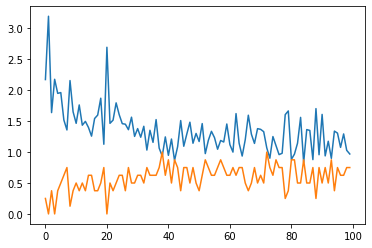

In [32]:
model = ModelM3()
BS = 8
losses,accur = [],[]
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=0.01, steps_per_epoch=(8), epochs=100)
for i in (w := trange(100)):
    
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp]).reshape(BS,-1,28,28).float()
    Y = torch.tensor(Y_train[samp]).long()
    optim.zero_grad()
    out = model(X)
    loss = loss_function(out, Y)
    loss.backward()
    optim.step()
    scheduler.step()
    losses.append(loss.item())
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    accur.append(accuracy.item())
    w.set_description("loss %.2f accuracy %.2f" % (loss.item(), accuracy.item()))

plot(losses)
plot(accur)

In [15]:
X_test[1].shape

(28, 28)

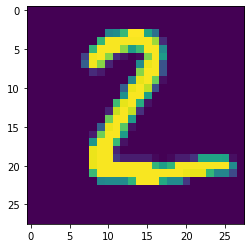

In [151]:
imshow(X_test[1])

In [29]:
model = ModelM3()
model.load_state_dict(torch.load("./pretrained/E_1000_B_256.pth"))
model.eval()
total_pred = np.zeros(0)
total_target = np.zeros(0)
correct =0 
BS = 256
with torch.no_grad():
    samp = np.random.randint(0, X_test.shape[0], size=(BS))
    X = torch.tensor(X_test[samp]).reshape(-1,1,28,28).float()
    Y = torch.tensor(Y_test[samp]).long()
    output = model(X)
    loss = loss_function(output, Y)  
    pred = output.argmax(dim=1, keepdim=True)
    total_pred = np.append(total_pred, pred.cpu().numpy())
    total_target = np.append(total_target, Y.cpu().numpy())
    correct += pred.eq(Y.view_as(pred)).sum().item()
print(((correct/BS)) * 100.)

99.21875


In [115]:
bb = torch.rand(28,28).reshape(-1,28,28).to("cuda")
bb = bb.reshape(-1,1,28,28)

In [123]:
a = model(torch.tensor(X_train[1]).reshape(1,1,28,28).float().to("cuda"))

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 10])

In [93]:
torch.
model(torch.tensor(X_train[0].reshape((-1, 28,28))).float())

AttributeError: 'numpy.ndarray' object has no attribute 'to'

(<matplotlib.image.AxesImage at 0x270090a43d0>, 5)

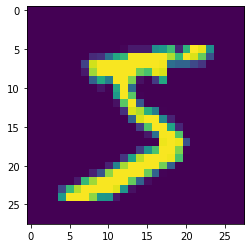

In [20]:
imshow(X_train[0]),Y_train[0]

In [51]:
X_train[0].shape

(28, 28)

In [54]:
samp = np.random.randint(0, X_train.shape[0], size=(32))
samp

array([35311, 39699, 26171, 46210, 17314, 43029, 37320, 39421, 58806,
       29027, 21664, 35228, 14039,  9742, 57421, 19143, 41468, 28862,
       16441, 26485, 49776, 36587, 43100, 58419, 47310, 56265, 25698,
       58223,  5034,  6004, 35192, 58064])

In [105]:
a = X_train[0].reshape(-1, 28*28)
b = X_train[0].reshape(2, (28*28)//2)

In [136]:
for i in range(10,30):
    a = model(torch.tensor(X_train[i].reshape((-1, 28*28))).float())
    print((torch.argmax(a) == Y_train[i]).float().mean())

tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)


In [97]:
bb = torch.rand(28,28).reshape(-1,28,28).to("cuda")
bb.shape

torch.Size([1, 28, 28])

In [61]:
X_train[0].reshape((-1, 28*28)).shape

(1, 784)

In [62]:
a = nn.Conv2d(1,32,3)

In [65]:
a(bb)

tensor([[[ 0.1618,  0.1397,  0.3568,  ...,  0.1558,  0.2665,  0.0075],
         [ 0.6869, -0.1422,  0.2693,  ...,  0.2233,  0.2592,  0.2933],
         [ 0.1258,  0.4293, -0.0053,  ..., -0.2310,  0.6334, -0.4554],
         ...,
         [ 0.0949,  0.4958,  0.0195,  ...,  0.0462,  0.3665,  0.0906],
         [ 0.5459, -0.0288,  0.4560,  ...,  0.3940, -0.1988,  0.6126],
         [ 0.1474, -0.0189,  0.3337,  ...,  0.2927,  0.1451,  0.1102]],

        [[ 0.0068,  0.0626, -0.0543,  ...,  0.1264, -0.0372, -0.0129],
         [-0.0153,  0.0819, -0.1621,  ..., -0.0580, -0.2075,  0.0852],
         [-0.2360,  0.1206, -0.1392,  ..., -0.1184, -0.3452, -0.0509],
         ...,
         [ 0.2140, -0.2147,  0.2343,  ..., -0.2713, -0.0888,  0.1101],
         [-0.0400, -0.3150,  0.1316,  ..., -0.1197, -0.0858, -0.0862],
         [-0.3938, -0.1825, -0.0984,  ..., -0.1842, -0.0376, -0.4042]],

        [[ 0.0050, -0.2309,  0.3010,  ...,  0.0614,  0.0505,  0.2873],
         [ 0.2879,  0.0100,  0.2387,  ..., -0